In [ ]:
import math
from dataclasses import dataclass
from typing import Dict, Optional, Tuple, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# -------------------------
# Parameters container
# -------------------------
@dataclass(frozen=True)
class SchemeParams:
    R: float = 1.0          # total reward per round
    beta: float = 0.99      # decay (0 < beta <= 1)
    k: int = 200            # recent-window length for soft-k RFG2
    L: float = 0.05         # tail ratio for soft-k RFG2 (0 <= L < 1)
    delta: Optional[float] = None  # for k-pseudo proportional; if None use R/k


def _geom_sum(beta: float, n: int) -> float:
    """Sum_{a=0}^{n-1} beta^a."""
    if n <= 0:
        return 0.0
    if beta == 1.0:
        return float(n)
    return (1.0 - beta**n) / (1.0 - beta)


# -------------------------
# Share reward vectors (end-of-round)
# -------------------------
def share_rewards_proportional(n: int, par: SchemeParams) -> np.ndarray:
    """Each share gets R/n."""
    if n <= 0:
        raise ValueError("n must be >= 1")
    return np.full(n, par.R / n, dtype=float)


def share_rewards_soft_k_rfg1(n: int, par: SchemeParams) -> np.ndarray:
    """
    soft-k RFG1:
      Update rule: whenever a new share arrives, multiply all existing weights by beta.
      -> End-of-round weights: w_j = beta^(n-j), j=1..n (last share weight 1)
      -> Rewards proportional to weights.
    """
    if n <= 0:
        raise ValueError("n must be >= 1")
    beta = par.beta
    if not (0.0 < beta <= 1.0):
        raise ValueError("beta must satisfy 0 < beta <= 1")

    # weights oldest..newest
    exps = np.arange(n-1, -1, -1, dtype=float)
    w = beta ** exps
    w_sum = w.sum()
    return par.R * (w / w_sum)


def share_rewards_soft_k_rfg2(n: int, par: SchemeParams) -> np.ndarray:
    """
    soft-k RFG2 (interpreted with tail ratio L):
      - If n <= k: same as RFG1
      - If n > k:
          Tail (first n-k shares) get total fraction L of reward, equally.
          Head (last k shares) get total fraction (1-L), distributed geometrically with beta.
    This matches "tail ratio L" = share of total weight allocated to shares beyond the recent k.
    """
    if n <= 0:
        raise ValueError("n must be >= 1")

    beta = par.beta
    k = int(par.k)
    L = float(par.L)

    if k <= 0:
        raise ValueError("k must be >= 1")
    if not (0.0 < beta <= 1.0):
        raise ValueError("beta must satisfy 0 < beta <= 1")
    if not (0.0 <= L < 1.0):
        raise ValueError("L must satisfy 0 <= L < 1")

    if n <= k:
        return share_rewards_soft_k_rfg1(n, par)

    tail_n = n - k
    head_n = k

    out = np.zeros(n, dtype=float)

    # Tail: equal split of L*R
    if tail_n > 0:
        out[:tail_n] = (par.R * L) / tail_n

    # Head: geometric weights over last k shares, total (1-L)*R
    exps = np.arange(head_n-1, -1, -1, dtype=float)  # oldest-in-head .. newest
    w = beta ** exps
    w_sum = w.sum()
    out[tail_n:] = (par.R * (1.0 - L)) * (w / w_sum)

    return out


def share_rewards_k_pseudo_proportional(n: int, par: SchemeParams) -> np.ndarray:
    """
    k-pseudo proportional (as in your slide):
      - If n < k: equal split R/n
      - If n >= k:
          share #k gets delta,
          shares #1..#(k-1) split R-delta equally,
          shares #(k+1)..#n get 0.
    """
    if n <= 0:
        raise ValueError("n must be >= 1")
    k = int(par.k)
    if k <= 1:
        raise ValueError("k must be >= 2 for k-pseudo proportional")

    delta = par.delta
    if delta is None:
        delta = par.R / k  # natural default
    if not (0.0 <= delta <= par.R):
        raise ValueError("delta must satisfy 0 <= delta <= R")

    if n < k:
        return share_rewards_proportional(n, par)

    out = np.zeros(n, dtype=float)
    out[:k-1] = (par.R - delta) / (k - 1)
    out[k-1] = delta
    return out


def share_rewards_ic_scheme_schrijvers(n: int, D: int, par: SchemeParams) -> np.ndarray:
    """
    Optional baseline: Schrijvers et al. IC reward (R_ic style):
      - If n >= D: proportional (R/n each share)
      - If n < D: each share gets R/D, and the last share (full solution finder) gets the remainder.
    Note: Requires D (expected shares per block) and assumes last share is the full solution.
    """
    if n <= 0:
        raise ValueError("n must be >= 1")
    if D <= 0:
        raise ValueError("D must be >= 1")
    if n >= D:
        return share_rewards_proportional(n, par)

    out = np.full(n, par.R / D, dtype=float)
    out[-1] += par.R * (1.0 - n / D)
    return out


SCHEMES: Dict[str, Callable[[int, SchemeParams], np.ndarray]] = {
    "proportional": share_rewards_proportional,
    "soft_k_rfg1": share_rewards_soft_k_rfg1,
    "soft_k_rfg2": share_rewards_soft_k_rfg2,
    "k_pseudo_proportional": share_rewards_k_pseudo_proportional,
}


In [ ]:
def absolute_redistribution_violation(scheme: str, n: int, par: SchemeParams) -> float:
    """
    Absolute redistribution axiom check (deviation):
      Compare allocations for first n shares between round length n and n+1.
      For absolute redistribution: a_i(n) - a_i(n+1) is constant across i.
      We return max(diff) - min(diff).
    """
    f = SCHEMES[scheme]
    a_n = f(n, par)               # length n
    a_np1 = f(n+1, par)[:n]       # first n shares
    diff = a_n - a_np1
    return float(diff.max() - diff.min())


def relative_redistribution_violation(scheme: str, n: int, par: SchemeParams, eps: float = 1e-15) -> float:
    """
    Relative redistribution axiom check (deviation):
      For relative redistribution: a_i(n+1) / a_i(n) is constant across i.
      We return max(ratio) - min(ratio) over shares with a_i(n) > eps.
    """
    f = SCHEMES[scheme]
    a_n = f(n, par)
    a_np1 = f(n+1, par)[:n]
    mask = a_n > eps
    if mask.sum() <= 1:
        return 0.0
    ratio = a_np1[mask] / a_n[mask]
    return float(ratio.max() - ratio.min())


def strict_positivity_ratio(scheme: str, n: int, par: SchemeParams, eps: float = 1e-15) -> float:
    """Fraction of shares with strictly positive reward."""
    f = SCHEMES[scheme]
    a = f(n, par)
    return float((a > eps).mean())


def estimate_share_marginal_value_profile(
    scheme: str,
    p: float,
    par: SchemeParams,
    t_max: int = 200,
    mc: int = 50_000,
    seed: int = 0,
) -> pd.DataFrame:
    """
    Proxy for 'local IC' / hopping incentive:
      v_t = E[ reward of share at position t | round survives to t ].

    Round length N ~ Geometric(p) (support 1..).
    Memoryless property => conditional N = (t-1) + Geometric(p).

    Returns DataFrame with columns: t, v_t.
    """
    if not (0.0 < p <= 1.0):
        raise ValueError("p must satisfy 0 < p <= 1")
    if t_max <= 0:
        raise ValueError("t_max must be >= 1")

    rng = np.random.default_rng(seed)
    f = SCHEMES[scheme]
    out_t = []
    out_v = []

    for t in range(1, t_max + 1):
        residual = rng.geometric(p, size=mc)  # >=1
        n = (t - 1) + residual                # >= t

        # vectorized: compute reward for share at position t given final length n
        v = np.zeros(mc, dtype=float)

        if scheme == "proportional":
            v = par.R / n

        elif scheme == "soft_k_rfg1":
            beta = par.beta
            if beta == 1.0:
                v = par.R / n
            else:
                denom = (1.0 - beta ** n) / (1.0 - beta)  # geom sum length n
                v = par.R * (beta ** (n - t)) / denom

        elif scheme == "soft_k_rfg2":
            beta = par.beta
            k = int(par.k)
            L = float(par.L)

            # case split per sample
            mask_short = n <= k
            if mask_short.any():
                n_s = n[mask_short]
                if beta == 1.0:
                    v[mask_short] = par.R / n_s
                else:
                    denom = (1.0 - beta ** n_s) / (1.0 - beta)
                    v[mask_short] = par.R * (beta ** (n_s - t)) / denom

            mask_long = ~mask_short
            if mask_long.any():
                n_l = n[mask_long]
                tail_n = n_l - k  # >=1
                # if t in tail: equal share of L*R
                in_tail = t <= tail_n
                # numpy broadcasting: in_tail is boolean array
                v_tail = (par.R * L) / tail_n
                # if t in head: geometric share of (1-L)*R
                if beta == 1.0:
                    v_head = (par.R * (1.0 - L)) / k
                else:
                    sum_head = (1.0 - beta ** k) / (1.0 - beta)
                    v_head = (par.R * (1.0 - L)) * (beta ** (n_l - t)) / sum_head

                v[mask_long] = np.where(in_tail, v_tail, v_head)

        elif scheme == "k_pseudo_proportional":
            k = int(par.k)
            delta = par.delta if par.delta is not None else par.R / k

            # if n < k => proportional
            mask_short = n < k
            if mask_short.any():
                v[mask_short] = par.R / n[mask_short]

            mask_long = ~mask_short
            if mask_long.any():
                if t < k:
                    v[mask_long] = (par.R - delta) / (k - 1)
                elif t == k:
                    v[mask_long] = delta
                else:
                    v[mask_long] = 0.0
        else:
            raise ValueError(f"Unsupported scheme: {scheme}")

        out_t.append(t)
        out_v.append(float(v.mean()))

    return pd.DataFrame({"t": out_t, "v_t": out_v})


def summarize_local_ic(profile: pd.DataFrame) -> Dict[str, float]:
    v = profile["v_t"].to_numpy()
    v_min = float(v.min())
    v_max = float(v.max())
    v_mean = float(v.mean())
    v_std = float(v.std(ddof=0))
    return {
        "v_min": v_min,
        "v_max": v_max,
        "v_range": v_max - v_min,
        "v_ratio": (v_max / v_min) if v_min > 0 else float("inf"),
        "v_cv": (v_std / v_mean) if v_mean > 0 else float("inf"),
    }


In [ ]:
def simulate_many_rounds(
    scheme: str,
    par: SchemeParams,
    p: float,
    miner_probs: np.ndarray,
    n_rounds: int = 50_000,
    seed: int = 0,
    max_round_len: int = 200_000,
) -> pd.DataFrame:
    """
    Simulate many independent rounds:
      - Round length N ~ Geometric(p)
      - Each share is attributed to a miner with probabilities miner_probs
      - End-of-round reward is allocated to shares by the scheme
      - Miner rewards are sums of their share rewards

    Returns a DataFrame of miner rewards per round: columns [round, miner, reward].
    """
    if scheme not in SCHEMES:
        raise ValueError(f"Unknown scheme: {scheme}")
    if not (0.0 < p <= 1.0):
        raise ValueError("p must satisfy 0 < p <= 1")

    miner_probs = np.asarray(miner_probs, dtype=float)
    if (miner_probs < 0).any() or not np.isclose(miner_probs.sum(), 1.0):
        raise ValueError("miner_probs must be a probability vector summing to 1")

    rng = np.random.default_rng(seed)
    f = SCHEMES[scheme]
    m = len(miner_probs)

    rows = []
    for r in range(n_rounds):
        # sample round length with cap (resample if too long)
        n = int(rng.geometric(p))
        while n > max_round_len:
            n = int(rng.geometric(p))

        miner_ids = rng.choice(m, size=n, p=miner_probs)
        share_rewards = f(n, par)  # length n, sum R

        miner_rewards = np.bincount(miner_ids, weights=share_rewards, minlength=m)
        for i in range(m):
            rows.append((r, i, float(miner_rewards[i])))

    return pd.DataFrame(rows, columns=["round", "miner", "reward"])


def miner_reward_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize miner reward distribution across rounds.
    Output columns: mean, std, cv, p5, p50, p95.
    """
    g = df.groupby("miner")["reward"]
    out = pd.DataFrame({
        "mean": g.mean(),
        "std": g.std(ddof=0),
        "p5": g.quantile(0.05),
        "p50": g.quantile(0.50),
        "p95": g.quantile(0.95),
    })
    out["cv"] = out["std"] / out["mean"]
    return out.reset_index()


proportional {'abs_dev': 0.0, 'rel_dev': 0.0, 'positivity_ratio': 1.0}
soft_k_rfg1 {'abs_dev': 0.00011511219788653236, 'rel_dev': 5.551115123125783e-16, 'positivity_ratio': 1.0}
soft_k_rfg2 {'abs_dev': 0.04912435074898971, 'rel_dev': 31.0554024680253, 'positivity_ratio': 1.0}
k_pseudo_proportional {'abs_dev': 0.0, 'rel_dev': 0.0, 'positivity_ratio': 0.25}
local-IC summary: {'v_min': 0.0009211843814745167, 'v_max': 0.005301027933277033, 'v_range': 0.0043798435518025165, 'v_ratio': 5.754578605416443, 'v_cv': 0.4333533031823229}


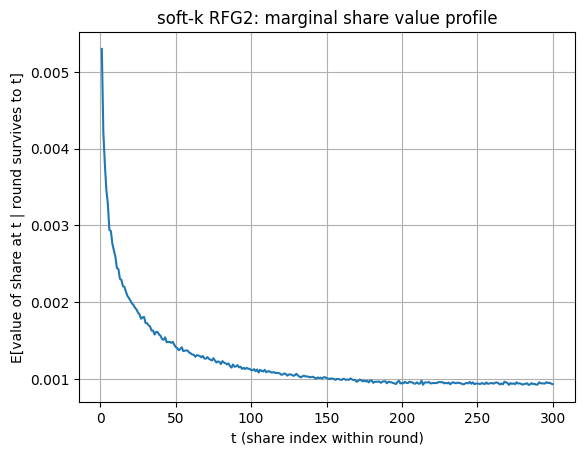

   miner      mean       std        p5       p50       p95        cv
0      0  0.499475  0.051603  0.428836  0.499747  0.571225  0.103314
1      1  0.300571  0.047636  0.235673  0.300346  0.365600  0.158486
2      2  0.199954  0.041639  0.144609  0.199711  0.256195  0.208244


In [ ]:
# --- Model parameters (from your plan) ---
R = 1.0
D = 1000                 # expected shares per block (toy but manageable)
p = 1.0 / D
beta = 0.99
k = 200
L = 0.05

par_rfg1 = SchemeParams(R=R, beta=beta, k=k, L=L)
par_rfg2 = SchemeParams(R=R, beta=beta, k=k, L=L)
par_kpp  = SchemeParams(R=R, beta=beta, k=50, L=L)  # k-pseudo needs k>=2

# --- Fairness/positivity quick checks ---
n_check = 200
for s, par in [("proportional", par_rfg1),
               ("soft_k_rfg1", par_rfg1),
               ("soft_k_rfg2", par_rfg2),
               ("k_pseudo_proportional", par_kpp)]:
    abs_v = absolute_redistribution_violation(s, n_check, par)
    rel_v = relative_redistribution_violation(s, n_check, par)
    pos   = strict_positivity_ratio(s, n_check, par)
    print(s, {"abs_dev": abs_v, "rel_dev": rel_v, "positivity_ratio": pos})

# --- Local-IC proxy profile (marginal share value by progress t) ---
profile = estimate_share_marginal_value_profile(
    scheme="soft_k_rfg2",
    p=p,
    par=par_rfg2,
    t_max=300,
    mc=50_000,
    seed=1,
)
print("local-IC summary:", summarize_local_ic(profile))

plt.figure()
plt.plot(profile["t"], profile["v_t"])
plt.xlabel("t (share index within round)")
plt.ylabel("E[value of share at t | round survives to t]")
plt.title("soft-k RFG2: marginal share value profile")
plt.grid(True)
plt.show()

# --- Miner-level simulation example (optional) ---
miner_probs = np.array([0.5, 0.3, 0.2])  # example mining power shares
df_sim = simulate_many_rounds(
    scheme="soft_k_rfg2",
    par=par_rfg2,
    p=p,
    miner_probs=miner_probs,
    n_rounds=10_000,
    seed=123,
)
print(miner_reward_summary(df_sim))


In [ ]:
def sweep_parameters(
    scheme: str,
    p: float,
    R: float,
    beta_list,
    k_list,
    L_list,
    t_max: int = 200,
    mc: int = 30_000,
    seed: int = 0,
) -> pd.DataFrame:
    rows = []
    for beta in beta_list:
        for k in k_list:
            for L in L_list:
                par = SchemeParams(R=R, beta=float(beta), k=int(k), L=float(L))
                prof = estimate_share_marginal_value_profile(
                    scheme=scheme, p=p, par=par, t_max=t_max, mc=mc, seed=seed
                )
                s = summarize_local_ic(prof)

                # fairness check at some representative n (you can average over n=1..N too)
                n0 = max(10, min(500, int(3/p)))  # heuristic representative round length
                abs_dev = absolute_redistribution_violation(scheme, n0, par)
                rel_dev = relative_redistribution_violation(scheme, n0, par)
                pos_ratio = strict_positivity_ratio(scheme, n0, par)

                rows.append({
                    "scheme": scheme,
                    "p": p,
                    "D": 1.0/p,
                    "beta": beta,
                    "k": k,
                    "L": L,
                    "n_ref": n0,
                    "abs_dev@ref": abs_dev,
                    "rel_dev@ref": rel_dev,
                    "positivity@ref": pos_ratio,
                    **s
                })
    return pd.DataFrame(rows)

beta_list = [0.90, 0.95, 0.98, 0.99]
k_list = [50, 100, 200, 400]
L_list = [0.01, 0.05, 0.10]

df_grid = sweep_parameters(
    scheme="soft_k_rfg2",
    p=p,
    R=R,
    beta_list=beta_list,
    k_list=k_list,
    L_list=L_list,
    t_max=200,
    mc=20_000,
    seed=0,
)
df_grid.sort_values(["v_cv", "rel_dev@ref"]).head(10)


,scheme,p,D,beta,k,L,n_ref,abs_dev@ref,rel_dev@ref,positivity@ref,v_min,v_max,v_range,v_ratio,v_cv
9,soft_k_rfg2,0.001,1000.0,0.9,400,0.01,500,0.009999,9.009901e-02,0.812,0.000877,0.003209,0.002332,3.660112,0.200904
6,soft_k_rfg2,0.001,1000.0,0.9,200,0.01,500,0.009933,4.280929e+05,1.000,0.000879,0.003219,0.002340,3.662159,0.201389
0,soft_k_rfg2,0.001,1000.0,0.9,50,0.01,500,0.009951,9.588727e-01,1.000,0.000872,0.003220,0.002347,3.691237,0.203729
3,soft_k_rfg2,0.001,1000.0,0.9,100,0.01,500,0.009922,7.634940e+00,1.000,0.000872,0.003228,0.002356,3.701730,0.203783
10,soft_k_rfg2,0.001,1000.0,0.9,400,0.05,500,0.009995,9.009901e-02,0.812,0.000920,0.003401,0.002481,3.695238,0.206387
7,soft_k_rfg2,0.001,1000.0,0.9,200,0.05,500,0.009666,2.230593e+06,1.000,0.000932,0.003453,0.002521,3.704438,0.209073
11,soft_k_rfg2,0.001,1000.0,0.9,400,0.10,500,0.009990,9.009901e-02,0.810,0.000975,0.003641,0.002666,3.734716,0.213483
8,soft_k_rfg2,0.001,1000.0,0.9,200,0.10,500,0.009332,4.709031e+06,1.000,0.000985,0.003746,0.002761,3.803843,0.219132
4,soft_k_rfg2,0.001,1000.0,0.9,100,0.05,500,0.009622,4.357153e+01,1.000,0.000898,0.003499,0.002601,3.898381,0.222539
1,soft_k_rfg2,0.001,1000.0,0.9,50,0.05,500,0.009549,7.950411e-01,1.000,0.000901,0.003474,0.002573,3.854835,0.224036


In [ ]:

# =========================
# Export (Chapter-3 structured): CSV + figures + ZIP
# =========================

from pathlib import Path
import json
import re
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Output paths ----
OUT_ROOT = Path("results_ch3")
CH3_DIR = OUT_ROOT / "3_simulation"
SETTINGS_DIR = CH3_DIR / "3_1_settings"
METRICS_DIR = CH3_DIR / "3_2_metrics"
PLOTS_DIR = METRICS_DIR / "plots"

for d in [SETTINGS_DIR, METRICS_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Global experiment settings (edit here) ----
R = 1.0
D_ic = 200          # difficulty proxy used in Schrijvers-IC (toy parameter)

# diagnostics over round length
N_MAX = 400         # compute for N=1..N_MAX-1
N_PROFILE = 200     # representative payout profile length for plotting/saving

# marginal-value (local-IC proxy) settings
T_VALUES = np.arange(0, 601, 10)  # t=0..600 step 10
MC_SAMPLES = 20000
RNG_SEED = 123

EPS = 1e-15

# ---- Helpers ----
def _scheme_model(s: str) -> str:
    s = str(s)
    if s.startswith("RFG1"):
        return "soft-k RFG1"
    if s.startswith("RFG2mix"):
        return "soft-k RFG2"
    if s.startswith("Schrijvers-IC"):
        return "IC"
    if s.startswith("k-pseudo"):
        return "k-pseudo proportional"
    if s.startswith("Proportional"):
        return "Proportional"
    return "Other"

# ---- Consistent colors by reward-function type (match tradeoff plot) ----
MODEL_COLORS = {
    "Proportional": "tab:blue",
    "k-pseudo proportional": "tab:orange",
    "IC": "tab:green",
    "soft-k RFG1": "tab:red",
    "soft-k RFG2": "tab:purple",
    "Other": "tab:gray",
}


def _slug(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^0-9A-Za-z._=-]+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s[:120]


def _parse_params(scheme_name: str) -> dict:
    '''
    Extract representative parameters from the scheme label for bookkeeping.
    This is best-effort parsing for export convenience (not for logic).
    '''
    d = {"R": float(R), "beta": None, "k": None, "L": None, "delta": None, "D_ic": None}
    if scheme_name.startswith("Proportional"):
        return d
    m = re.search(r"k-pseudo\s*k=(\d+)\s*delta=([0-9.]+)", scheme_name)
    if m:
        d["k"] = int(m.group(1))
        d["delta"] = float(m.group(2))
        return d
    m = re.search(r"RFG1\s*beta=([0-9.]+)", scheme_name)
    if m:
        d["beta"] = float(m.group(1))
        return d
    m = re.search(r"RFG2mix\s*k=(\d+)\s*L=([0-9.]+)\s*beta=([0-9.]+)", scheme_name)
    if m:
        d["k"] = int(m.group(1))
        d["L"] = float(m.group(2))
        d["beta"] = float(m.group(3))
        return d
    if scheme_name.startswith("Schrijvers-IC"):
        d["D_ic"] = int(D_ic)
        return d
    return d


def _line_plot(df: pd.DataFrame, x: str, y: str, group: str, title: str, outpath: Path, ylog: bool = False):
    plt.figure(figsize=(10, 5))
    for g, sub in df.groupby(group):
        xs = sub[x].to_numpy()
        ys = sub[y].to_numpy()
        if ylog:
            ys = np.where(ys > 0, ys, np.nan)

        color = None
        if group == "scheme":
            model = _scheme_model(str(g))
            color = MODEL_COLORS.get(model, "tab:gray")
        elif group == "model":
            color = MODEL_COLORS.get(str(g), "tab:gray")

        plt.plot(xs, ys, label=str(g), color=color)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    if ylog:
        plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()


# ---- Scheme factory (same logic as before; we export bookkeeping) ----
def _make_schemes(R: float, D_ic: int):
    schemes = []

    # Proportional
    par = SchemeParams(R=R)
    schemes.append(("Proportional", lambda N, par=par: share_rewards_proportional(N, par)))

    # k-pseudo proportional (multiple k)
    k_list = [40, 100, 150, 180]
    delta = 0.2
    for k_pp in k_list:
        par = SchemeParams(R=R, k=k_pp, delta=delta)
        schemes.append(
            (f"k-pseudo k={k_pp} delta={delta}",
             lambda N, par=par: share_rewards_k_pseudo_proportional(N, par))
        )

    # soft-k RFG1 (beta sweep)
    for beta in [0.99, 0.95, 0.90, 0.85, 0.70]:
        par = SchemeParams(R=R, beta=beta)
        schemes.append((f"RFG1 beta={beta}", lambda N, par=par: share_rewards_soft_k_rfg1(N, par)))

    # soft-k RFG2 (subset sweep)
    k = 40
    rfg2_specs = [
        (0.95, 0.20),
        (0.99, 0.20),
        (0.90, 0.50),
        (0.90, 0.20),
        (0.90, 0.05),
        (0.85, 0.20),
        (0.70, 0.20),
    ]
    for beta, L in rfg2_specs:
        par = SchemeParams(R=R, beta=beta, k=k, L=L)
        schemes.append((f"RFG2mix k={k} L={L} beta={beta}", lambda N, par=par: share_rewards_soft_k_rfg2(N, par)))

    # Schrijvers-IC (simplified)
    par = SchemeParams(R=R)
    schemes.append(("Schrijvers-IC", lambda N, par=par: share_rewards_ic_scheme_schrijvers(N, D=D_ic, par=par)))

    return schemes


SCHEME_LIST = _make_schemes(R=R, D_ic=D_ic)

# ---- 3.1 Settings export ----
print("[1/6] Exporting 3.1 settings ...")

situation = {
    "R": float(R),
    "D_ic": int(D_ic),
    "N_MAX": int(N_MAX),
    "N_PROFILE": int(N_PROFILE),
    "T_VALUES": [int(x) for x in T_VALUES],
    "MC_SAMPLES": int(MC_SAMPLES),
    "RNG_SEED": int(RNG_SEED),
    "EPS": float(EPS),
}
(SETTINGS_DIR / "3_1_1_situation_parameters.json").write_text(
    json.dumps(situation, ensure_ascii=False, indent=2),
    encoding="utf-8",
)

scheme_rows = []
for name, _ in SCHEME_LIST:
    scheme_rows.append({"scheme": name, "model": _scheme_model(name), **_parse_params(name)})

pd.DataFrame(scheme_rows).to_csv(SETTINGS_DIR / "3_1_scheme_list.csv", index=False)
(SETTINGS_DIR / "3_1_scheme_list.json").write_text(
    json.dumps(scheme_rows, ensure_ascii=False, indent=2),
    encoding="utf-8",
)

# representative payout profile per scheme (N_PROFILE)
PROFILE_DIR = SETTINGS_DIR / f"profiles_N{int(N_PROFILE)}"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)

for name, fn in SCHEME_LIST:
    a = fn(int(N_PROFILE)).astype(float)
    pd.DataFrame({"j": np.arange(1, int(N_PROFILE) + 1), "payout": a}).to_csv(
        PROFILE_DIR / f"{_slug(name)}.csv", index=False
    )

# one combined plot (quick inspection)
plt.figure(figsize=(10, 5))
x = np.arange(1, int(N_PROFILE) + 1)
for name, fn in SCHEME_LIST:
    model = _scheme_model(name)
    color = MODEL_COLORS.get(model, "tab:gray")
    plt.plot(x, fn(int(N_PROFILE)), label=name, color=color)
plt.xlabel("Share position j in the round")
plt.ylabel("Payout for share j")
plt.title(f"Representative payout profiles (N={int(N_PROFILE)})")
plt.legend(fontsize=7)
plt.tight_layout()
plt.savefig(PROFILE_DIR / f"payout_profile_N{int(N_PROFILE)}_all.png", dpi=200)
plt.close()

# ---- Diagnostics base tables ----
def diagnostics_base_df(schemes, N_max: int, eps: float = 1e-15) -> pd.DataFrame:
    rows = []
    for name, fn in schemes:
        model = _scheme_model(name)
        for N in range(1, N_max):
            aN = fn(N).astype(float)
            aNp1 = fn(N + 1).astype(float)

            diffs = aN - aNp1[:N]
            abs_err = float(diffs.max() - diffs.min())
            abs_std = float(np.std(diffs, ddof=0))

            mask = aN > eps
            if int(mask.sum()) >= 2:
                ratios = aNp1[:N][mask] / aN[mask]
                rel_err = float(ratios.max() - ratios.min())
                rel_std = float(np.std(ratios, ddof=0))
            else:
                rel_err = float("nan")
                rel_std = float("nan")

            min_payout = float(np.min(aN))
            zero_count = int(np.sum(aN == 0.0))
            zero_frac = float(zero_count / float(N))

            rows.append(
                {
                    "scheme": name,
                    "model": model,
                    "N": int(N),
                    "abs_red_error": abs_err,
                    "abs_red_std": abs_std,
                    "rel_red_error": rel_err,
                    "rel_red_std": rel_std,
                    "min_payout": min_payout,
                    "zero_count": zero_count,
                    "zero_frac": zero_frac,
                }
            )
    return pd.DataFrame(rows)


def expected_marginal_value_df(
    schemes,
    D: int,
    t_values: np.ndarray,
    mc_samples: int,
    seed: int,
    R: float,
) -> pd.DataFrame:
    '''
    Estimate V(t)=E[payout of share at position j=t+1 | N>t] using:
      N = t + M, M ~ Geometric(p=1/D).
    Also export V_rel normalized by V(0), and ic_error=|V_rel-1|.
    '''
    rng = np.random.default_rng(seed)
    p = 1.0 / float(D)

    def sample_geometric(size: int) -> np.ndarray:
        return rng.geometric(p, size=size)

    rows = []
    for name, fn in schemes:
        model = _scheme_model(name)
        V_list = []
        for t in t_values.astype(int):
            M = sample_geometric(mc_samples)
            N = t + M
            j = t + 1

            vals = np.empty(mc_samples, dtype=float)

            unique_N, inv = np.unique(N, return_inverse=True)
            for idx, N_val in enumerate(unique_N):
                a = fn(int(N_val)).astype(float)
                vals[inv == idx] = a[j - 1]

            V = float(vals.mean())
            V_list.append((t, V))

        V0 = V_list[0][1]
        for t, V in V_list:
            V_rel = float(V / V0) if V0 > 0 else float("nan")
            ic_err = float(abs(V_rel - 1.0)) if np.isfinite(V_rel) else float("nan")
            rows.append({"scheme": name, "model": model, "t": int(t), "V": float(V), "V_rel": V_rel, "ic_error": ic_err})

    return pd.DataFrame(rows)


print("[2/6] Computing base diagnostics over N ...")
base_df = diagnostics_base_df(SCHEME_LIST, N_max=N_MAX, eps=EPS)

print("[3/6] Computing marginal-value / IC proxy over t ...")
mv_df = expected_marginal_value_df(
    SCHEME_LIST,
    D=D_ic,
    t_values=T_VALUES,
    mc_samples=MC_SAMPLES,
    seed=RNG_SEED,
    R=R,
)

print("[4/6] Exporting 3.2 metrics (split by axis) ...")

# 3.2.1 Absolute redistribution error
abs_df = base_df[["scheme", "model", "N", "abs_red_error", "abs_red_std"]].copy()
abs_df.to_csv(METRICS_DIR / "3_2_1_absolute_redistribution_error.csv", index=False)

# 3.2.2 Relative redistribution error
rel_df = base_df[["scheme", "model", "N", "rel_red_error", "rel_red_std"]].copy()
rel_df.to_csv(METRICS_DIR / "3_2_2_relative_redistribution_error.csv", index=False)

# 3.2.3 Incentive compatibility error (proxy)
ic_curve_df = mv_df[["scheme", "model", "t", "V", "V_rel", "ic_error"]].copy()
ic_curve_df.to_csv(METRICS_DIR / "3_2_3_incentive_compatibility_error_by_t.csv", index=False)

tail = ic_curve_df[ic_curve_df["t"] >= 50].copy()
ic_summary = (
    tail.groupby(["scheme", "model"], as_index=False)
    .agg(
        ic_error_mean=("ic_error", "mean"),
        ic_error_max=("ic_error", "max"),
        V_rel_std=("V_rel", lambda x: float(np.std(x.to_numpy(), ddof=0))),
        V_rel_min=("V_rel", "min"),
        V_rel_max=("V_rel", "max"),
    )
)
ic_summary.to_csv(METRICS_DIR / "3_2_3_incentive_compatibility_error_summary.csv", index=False)

# 3.2.4 Positivity (strict-positivity proxies)
pos_df = base_df[["scheme", "model", "N", "min_payout", "zero_count", "zero_frac"]].copy()
pos_df.to_csv(METRICS_DIR / "3_2_4_positivity.csv", index=False)

# overall compact summary
mid = base_df[base_df["N"] >= 50].copy()
fair_summary = (
    mid.groupby(["scheme", "model"], as_index=False)
    .agg(
        abs_red_error_mean=("abs_red_error", "mean"),
        rel_red_error_mean=("rel_red_error", "mean"),
        min_payout_min=("min_payout", "min"),
        zero_frac_max=("zero_frac", "max"),
    )
)

summary_all = fair_summary.merge(ic_summary, on=["scheme", "model"], how="left")
summary_all.to_csv(METRICS_DIR / "3_2_summary_all.csv", index=False)

print("[5/6] Saving figures (one axis each) ...")

_line_plot(
    abs_df,
    x="N",
    y="abs_red_error",
    group="scheme",
    title="Absolute redistribution error vs round length N",
    outpath=PLOTS_DIR / "3_2_1_absolute_redistribution_error.png",
    ylog=True,
)

_line_plot(
    rel_df,
    x="N",
    y="rel_red_error",
    group="scheme",
    title="Relative redistribution error vs round length N",
    outpath=PLOTS_DIR / "3_2_2_relative_redistribution_error.png",
    ylog=True,
)

_line_plot(
    ic_curve_df,
    x="t",
    y="ic_error",
    group="scheme",
    title="IC error proxy vs round progress t (|V_rel(t) - 1|)",
    outpath=PLOTS_DIR / "3_2_3_incentive_compatibility_error.png",
    ylog=False,
)

_line_plot(
    pos_df,
    x="N",
    y="min_payout",
    group="scheme",
    title="Min payout within a round vs round length N (positivity proxy)",
    outpath=PLOTS_DIR / "3_2_4_min_payout.png",
    ylog=True,
)

_line_plot(
    pos_df,
    x="N",
    y="zero_frac",
    group="scheme",
    title="Zero payout fraction vs round length N (positivity proxy)",
    outpath=PLOTS_DIR / "3_2_4_zero_fraction.png",
    ylog=False,
)



# ---- Per-model (reward-function type) tables + plots (for Chapter 4.1 subsections) ----
BY_MODEL_DIR = PLOTS_DIR / "by_model"
BY_MODEL_DIR.mkdir(parents=True, exist_ok=True)

BY_MODEL_TABLE_DIR = METRICS_DIR / "by_model_tables"
BY_MODEL_TABLE_DIR.mkdir(parents=True, exist_ok=True)

def _safe_filename(name: str) -> str:
    s = re.sub(r"[^A-Za-z0-9_\-]+", "_", str(name))
    s = re.sub(r"_+", "_", s).strip("_")
    return s if len(s) > 0 else "name"

# Merge scheme metadata (params) with summary metrics for easy "table per model"
meta_df = pd.DataFrame(scheme_rows)  # created in 3.1 export section above
summary_meta = meta_df.merge(summary_all, on=["scheme", "model"], how="left")

# Save per-model summary tables + per-model multi-line plots
for model_name in sorted(summary_meta["model"].dropna().unique()):
    safe_model = _safe_filename(model_name)

    # ---- Tables (CSV) ----
    tab = summary_meta[summary_meta["model"] == model_name].copy()
    tab = tab.sort_values(["scheme"]).reset_index(drop=True)
    tab.to_csv(BY_MODEL_TABLE_DIR / f"{safe_model}__summary_table.csv", index=False)

    # Also save the underlying curves for reproducibility (optional but convenient)
    abs_sub = abs_df[abs_df["model"] == model_name].copy()
    rel_sub = rel_df[rel_df["model"] == model_name].copy()
    pos_sub = pos_df[pos_df["model"] == model_name].copy()
    ic_sub  = ic_curve_df[ic_curve_df["model"] == model_name].copy()

    abs_sub.to_csv(BY_MODEL_TABLE_DIR / f"{safe_model}__abs_curve.csv", index=False)
    rel_sub.to_csv(BY_MODEL_TABLE_DIR / f"{safe_model}__rel_curve.csv", index=False)
    pos_sub.to_csv(BY_MODEL_TABLE_DIR / f"{safe_model}__pos_curve.csv", index=False)
    ic_sub.to_csv(BY_MODEL_TABLE_DIR / f"{safe_model}__ic_curve.csv", index=False)

    # ---- Plots (PNG) : metrics indexed by N ----
    if not abs_sub.empty:
        _line_plot(
            abs_sub,
            x="N",
            y="abs_red_error",
            group="scheme",
            title=f"{model_name}: Absolute redistribution error vs N",
            outpath=BY_MODEL_DIR / f"{safe_model}__abs_red_error_vs_N.png",
            ylog=True,
        )

    if not rel_sub.empty:
        _line_plot(
            rel_sub,
            x="N",
            y="rel_red_error",
            group="scheme",
            title=f"{model_name}: Relative redistribution error vs N",
            outpath=BY_MODEL_DIR / f"{safe_model}__rel_red_error_vs_N.png",
            ylog=True,
        )

    if not pos_sub.empty:
        _line_plot(
            pos_sub,
            x="N",
            y="min_payout",
            group="scheme",
            title=f"{model_name}: Min payout vs N (positivity proxy)",
            outpath=BY_MODEL_DIR / f"{safe_model}__min_payout_vs_N.png",
            ylog=True,
        )

        _line_plot(
            pos_sub,
            x="N",
            y="zero_frac",
            group="scheme",
            title=f"{model_name}: Zero payout fraction vs N (positivity proxy)",
            outpath=BY_MODEL_DIR / f"{safe_model}__zero_frac_vs_N.png",
            ylog=False,
        )

    # ---- Plots (PNG) : IC proxy indexed by t ----
    if not ic_sub.empty:
        _line_plot(
            ic_sub,
            x="t",
            y="ic_error",
            group="scheme",
            title=f"{model_name}: IC error proxy vs t (|V_rel(t) - 1|)",
            outpath=BY_MODEL_DIR / f"{safe_model}__ic_error_vs_t.png",
            ylog=False,
        )
        _line_plot(
            ic_sub,
            x="t",
            y="V_rel",
            group="scheme",
            title=f"{model_name}: V_rel(t) = V(t)/V(0) vs t",
            outpath=BY_MODEL_DIR / f"{safe_model}__V_rel_vs_t.png",
            ylog=False,
        )




# Tradeoff scatter (colored by model) + parameter annotations for soft-k RFGs
# Produce BOTH:
#   - relative redistribution error vs IC proxy
#   - absolute redistribution error vs IC proxy
#
# The default filename (3_2_tradeoff_scatter_by_model.png) is set to the REL version for convenience.

# Use the merged table so parameters (beta/k/L/...) are available
plot_df = summary_meta.copy()
plot_df = plot_df[np.isfinite(plot_df["ic_error_mean"])].copy()

# Consistent legend ordering
model_order = ["Proportional", "k-pseudo proportional", "IC", "soft-k RFG1", "soft-k RFG2", "Other"]

def _fmt(x):
    """Compact parameter formatter for annotations."""
    if x is None:
        return "?"
    try:
        # handle numpy scalars
        if isinstance(x, (np.integer, int)):
            return str(int(x))
        xf = float(x)
        if not np.isfinite(xf):
            return "?"
        # 3 significant digits keeps 0.95 / 0.99 / 0.05 readable
        return f"{xf:.3g}"
    except Exception:
        return str(x)

def _tradeoff_scatter(x_col: str, x_label: str, filename: str, eps_name: str) -> None:
    # For log-x, replace zeros with a small epsilon for plotting (and note it on the figure)
    x_raw = plot_df[x_col].to_numpy()
    pos = x_raw[np.isfinite(x_raw) & (x_raw > 0)]
    eps_x = float(pos.min() / 10.0) if pos.size > 0 else 1e-12

    x_plot_col = x_col.replace("_mean", "_plot") if x_col.endswith("_mean") else (x_col + "_plot")
    plot_df[x_plot_col] = np.where(
        np.isfinite(plot_df[x_col]) & (plot_df[x_col] > 0),
        plot_df[x_col],
        eps_x,
    )

    plt.figure(figsize=(10, 6))

    # scatter by model (color fixed by MODEL_COLORS)
    for model in model_order:
        sub = plot_df[plot_df["model"] == model]
        if sub.empty:
            continue
        plt.scatter(
            sub[x_plot_col],
            sub["ic_error_mean"],
            s=60,
            alpha=0.9,
            label=model,
            color=MODEL_COLORS.get(model, MODEL_COLORS.get("Other", "tab:gray")),
        )

    # annotate soft-k parameters
    for _, row in plot_df.iterrows():
        if row["model"] == "soft-k RFG1":
            txt = f"β={_fmt(row.get('beta'))}"
        elif row["model"] == "soft-k RFG2":
            ktxt = _fmt(row.get("k"))
            Ltxt = _fmt(row.get("L"))
            btxt = _fmt(row.get("beta"))
            txt = f"k={ktxt}, L={Ltxt}, β={btxt}"
        else:
            continue

        plt.annotate(
            txt,
            (row[x_plot_col], row["ic_error_mean"]),
            textcoords="offset points",
            xytext=(4, 4),
            fontsize=7,
            alpha=0.85,
        )

    # If any schemes have x==0, they are plotted at eps_x on log scale
    if np.any(~np.isfinite(plot_df[x_col])) or np.any(plot_df[x_col] <= 0):
        plt.text(
            0.98,
            0.02,
            f"{eps_name}=0 plotted at ε={eps_x:.1e}",
            transform=plt.gca().transAxes,
            ha="right",
            va="bottom",
            fontsize=8,
            alpha=0.7,
        )

    plt.xscale("log")
    plt.xlabel(x_label)
    plt.ylabel("Mean IC error proxy (t>=50) [lower is closer to IC]")
    plt.title(f"Fairness vs IC proxy (summary) — {eps_name}")
    plt.grid(True, which="both", linestyle="--", alpha=0.35)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=200)
    plt.close()

# Relative fairness (relative redistribution error) vs IC proxy
_tradeoff_scatter(
    x_col="rel_red_error_mean",
    x_label="Mean relative redistribution error (N>=50) [lower is fairer]",
    filename="3_2_tradeoff_scatter_by_model_rel.png",
    eps_name="rel_red_error",
)

# Absolute fairness (absolute redistribution error) vs IC proxy
_tradeoff_scatter(
    x_col="abs_red_error_mean",
    x_label="Mean absolute redistribution error (N>=50) [lower is fairer]",
    filename="3_2_tradeoff_scatter_by_model_abs.png",
    eps_name="abs_red_error",
)

# Keep the original filename pointing to the REL version
try:
    shutil.copyfile(PLOTS_DIR / "3_2_tradeoff_scatter_by_model_rel.png", PLOTS_DIR / "3_2_tradeoff_scatter_by_model.png")
except Exception:
    pass



print("[6/6] Creating results_ch3.zip ...")
zip_path = Path("results_ch3.zip")
if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, p.relative_to(OUT_ROOT.parent))

print("Done.")
print("Artifacts:")
print(" -", zip_path.resolve())
print(" -", OUT_ROOT.resolve())


[1/5] Computing fairness_diagnostics.csv ...
[2/5] Computing marginal_value.csv ...
[3/5] Building parameter_sweep_summary.csv ...
[4/5] Saving figures ...
[5/5] Creating results_demo.zip ...
Done.
Artifacts:
 - /content/results_demo.zip
 - /content/results_demo/fairness_diagnostics.csv
 - /content/results_demo/marginal_value.csv
 - /content/results_demo/parameter_sweep_summary.csv
 - /content/results_demo/plots/payout_profile_N200.png
 - /content/results_demo/plots/min_payout.png
 - /content/results_demo/plots/abs_red_dev.png
 - /content/results_demo/plots/rel_red_dev.png
 - /content/results_demo/plots/marginal_value_rel.png
 - /content/results_demo/plots/tradeoff_scatter.png
